In [1]:
# basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# preprocess
from sklearn.preprocessing import LabelEncoder

# model
import lightgbm as lgb

# optimization
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error as MSE

# other
import pickle
import time
import sys
import gc

In [2]:
# set index to ID to avoid droping it later
test  = pd.read_csv('../data/input/test.csv').set_index('ID')

In [3]:
data = pd.read_pickle('../features/data.pkl')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5694622 entries, 4111216 to 9805837
Data columns (total 39 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_4                  float16
 12  item_cnt_month_lag_5                  float16
 13  item_cnt_month_lag_6                  float16
 14  item_cnt_month_lag_9                  float16
 15  item_cnt_

In [4]:
data.drop(
    [
        'date_shop_type_avg_item_cnt_lag_1',
        'date_shop_subtype_avg_item_cnt_lag_1',
        'date_type_avg_item_cnt_lag_1',
        'date_subtype_avg_item_cnt_lag_1'
    ],
    axis=1,
    inplace=True
)

In [5]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
del data
gc.collect();

In [7]:
class Model:

    def __init__(self, params=None):
        self.model = None
        if params is None:
            self.params = {}
        else:
            self.params = params

    def fit(self, tr_x, tr_y, va_x, va_y):
        params = {
            'task':'train',
            'objective':'regression',
            'seed':71,
            'boosting_type':'gbdt',
            'verbosity':-1,
            'metrics':'l2',
            'min_child_weight':1,
            'max_depth':5,
            'num_leaves':31,
            'num_iterations':100, 
            'gamma':0.0,
            #'alpha':0.0,
            #'lambda':1.0,
            'learning_rate':0.1,
            'feature_fraction':0.9, # colsample_bytree
            'bagging_fraction':0.8, # subsample
            'bagging_freq':5,
        }
        params.update(self.params)
        num_round = 10
        dtrain = lgb.Dataset(tr_x, tr_y)
        dvalid = lgb.Dataset(va_x, va_y)
        #watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        self.model = lgb.train(
            params, 
            dtrain, 
            num_boost_round=num_round,
            valid_sets=dvalid
        )
        
    def predict(self, x):
        #data = lgb.Dataset(x)
        pred = self.model.predict(x)
        return pred

In [8]:
def score(params):
    params['max_depth'] = int(params['max_depth'])
    
    model = Model(params)
    model.fit(X_train, Y_train, X_valid, Y_valid)
    Y_pred = model.predict(X_valid)
    score = np.sqrt(MSE(y_true=Y_valid, y_pred=Y_pred))
    print(f'params: {params}, score:{score:.4f}')
    
    history.append((params, score))
    return {'loss':score, 'status':STATUS_OK}

In [9]:
space = {
    'min_child_weight': hp.quniform('min_child_weight', 1, 5, 1),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    #'bagging_fraction': hp.quniform('bagging_fraction', 0.6, 0.95, 0.05),
    #'feature_fraction': hp.quniform('feature_fraction', 0.6, 0.95, 0.05),
    'gamma': hp.quniform('gamma', 0.1, 0.4, 0.1),
    # 余裕があればalpha, lambdaも調整する
    # 'alpha' : hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
    # 'lambda' : hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
}

In [10]:
max_evals = 10
trials = Trials()
history = []
fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07015                             
[2]	valid_0's l2: 1.02213                             
[3]	valid_0's l2: 0.982502                            
[4]	valid_0's l2: 0.951061                            
[5]	valid_0's l2: 0.926471                            
[6]	valid_0's l2: 0.904274                            
[7]	valid_0's l2: 0.886664                            
[8]	valid_0's l2: 0.872808                            
[9]	valid_0's l2: 0.860585                            
[10]	valid_0's l2: 0.849284                           
[11]	valid_0's l2: 0.839921                           
[12]	valid_0's l2: 0.833469                           
[13]	valid_0's l2: 0.82745                            
[14]	valid_0's l2: 0.821695                           
[15]	valid_0's l2: 0.817708                           
[16]	valid_0's l2: 0.814144                           
[17]	valid_0's l2: 0.810088                           
[18]	valid_0's l2: 0.807512                           
[19]	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07226                                                       
[2]	valid_0's l2: 1.02565                                                       
[3]	valid_0's l2: 0.988105                                                      
[4]	valid_0's l2: 0.956574                                                      
[5]	valid_0's l2: 0.932027                                                      
[6]	valid_0's l2: 0.911436                                                      
[7]	valid_0's l2: 0.894479                                                      
[8]	valid_0's l2: 0.879559                                                      
[9]	valid_0's l2: 0.866874                                                      
[10]	valid_0's l2: 0.856665                                                     
[11]	valid_0's l2: 0.848372                                                     
[12]	valid_0's l2: 0.841317                                                     
[13]	valid_0's l2: 0.835184 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06912                                                       
[2]	valid_0's l2: 1.02079                                                       
[3]	valid_0's l2: 0.979993                                                      
[4]	valid_0's l2: 0.948412                                                      
[5]	valid_0's l2: 0.921541                                                      
[6]	valid_0's l2: 0.89992                                                       
[7]	valid_0's l2: 0.881743                                                      
[8]	valid_0's l2: 0.866408                                                      
[9]	valid_0's l2: 0.854027                                                      
[10]	valid_0's l2: 0.843394                                                     
[11]	valid_0's l2: 0.834501                                                     
[12]	valid_0's l2: 0.827836                                                     
[13]	valid_0's l2: 0.821821 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07226                                                       
[2]	valid_0's l2: 1.02565                                                       
[3]	valid_0's l2: 0.988105                                                      
[4]	valid_0's l2: 0.956574                                                      
[5]	valid_0's l2: 0.932027                                                      
[6]	valid_0's l2: 0.911436                                                      
[7]	valid_0's l2: 0.894479                                                      
[8]	valid_0's l2: 0.879559                                                      
[9]	valid_0's l2: 0.866874                                                      
[10]	valid_0's l2: 0.856665                                                     
[11]	valid_0's l2: 0.848372                                                     
[12]	valid_0's l2: 0.841317                                                     
[13]	valid_0's l2: 0.835184 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06876                                                       
[2]	valid_0's l2: 1.01997                                                       
[3]	valid_0's l2: 0.97843                                                       
[4]	valid_0's l2: 0.946045                                                      
[5]	valid_0's l2: 0.920883                                                      
[6]	valid_0's l2: 0.898366                                                      
[7]	valid_0's l2: 0.880729                                                      
[8]	valid_0's l2: 0.866305                                                      
[9]	valid_0's l2: 0.853988                                                      
[10]	valid_0's l2: 0.84376                                                      
[11]	valid_0's l2: 0.834598                                                     
[12]	valid_0's l2: 0.827978                                                     
[13]	valid_0's l2: 0.822014 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06876                                                       
[2]	valid_0's l2: 1.01997                                                       
[3]	valid_0's l2: 0.97843                                                       
[4]	valid_0's l2: 0.946045                                                      
[5]	valid_0's l2: 0.920883                                                      
[6]	valid_0's l2: 0.898366                                                      
[7]	valid_0's l2: 0.880729                                                      
[8]	valid_0's l2: 0.866305                                                      
[9]	valid_0's l2: 0.853988                                                      
[10]	valid_0's l2: 0.84376                                                      
[11]	valid_0's l2: 0.834598                                                     
[12]	valid_0's l2: 0.827978                                                     
[13]	valid_0's l2: 0.822014 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06912                                                       
[2]	valid_0's l2: 1.02079                                                       
[3]	valid_0's l2: 0.979993                                                      
[4]	valid_0's l2: 0.948412                                                      
[5]	valid_0's l2: 0.921541                                                      
[6]	valid_0's l2: 0.89992                                                       
[7]	valid_0's l2: 0.881743                                                      
[8]	valid_0's l2: 0.866408                                                      
[9]	valid_0's l2: 0.854027                                                      
[10]	valid_0's l2: 0.843394                                                     
[11]	valid_0's l2: 0.834501                                                     
[12]	valid_0's l2: 0.827836                                                     
[13]	valid_0's l2: 0.821821 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.06955                                                       
[2]	valid_0's l2: 1.02134                                                       
[3]	valid_0's l2: 0.981037                                                      
[4]	valid_0's l2: 0.949929                                                      
[5]	valid_0's l2: 0.922931                                                      
[6]	valid_0's l2: 0.900973                                                      
[7]	valid_0's l2: 0.88236                                                       
[8]	valid_0's l2: 0.868754                                                      
[9]	valid_0's l2: 0.85643                                                       
[10]	valid_0's l2: 0.845849                                                     
[11]	valid_0's l2: 0.836038                                                     
[12]	valid_0's l2: 0.829652                                                     
[13]	valid_0's l2: 0.823727 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.0678                                                        
[2]	valid_0's l2: 1.01825                                                       
[3]	valid_0's l2: 0.977196                                                      
[4]	valid_0's l2: 0.945106                                                      
[5]	valid_0's l2: 0.918812                                                      
[6]	valid_0's l2: 0.896433                                                      
[7]	valid_0's l2: 0.878214                                                      
[8]	valid_0's l2: 0.863643                                                      
[9]	valid_0's l2: 0.851394                                                      
[10]	valid_0's l2: 0.840942                                                     
[11]	valid_0's l2: 0.832268                                                     
[12]	valid_0's l2: 0.824782                                                     
[13]	valid_0's l2: 0.817828 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[1]	valid_0's l2: 1.07226                                                       
[2]	valid_0's l2: 1.02565                                                       
[3]	valid_0's l2: 0.988105                                                      
[4]	valid_0's l2: 0.956574                                                      
[5]	valid_0's l2: 0.932027                                                      
[6]	valid_0's l2: 0.911436                                                      
[7]	valid_0's l2: 0.894479                                                      
[8]	valid_0's l2: 0.879559                                                      
[9]	valid_0's l2: 0.866874                                                      
[10]	valid_0's l2: 0.856665                                                     
[11]	valid_0's l2: 0.848372                                                     
[12]	valid_0's l2: 0.841317                                                     
[13]	valid_0's l2: 0.835184 

{'gamma': 0.2, 'max_depth': 9.0, 'min_child_weight': 2.0}

In [11]:
history = sorted(history, key=lambda tpl:tpl[1])
best = history[0]
print(f'best params:{best[0]}, score:{best[1]:.4f}')

best params:{'gamma': 0.2, 'max_depth': 9, 'min_child_weight': 2.0}, score:0.8774


In [12]:
dtrain = lgb.Dataset(X_train, Y_train)
dvalid = lgb.Dataset(X_valid, Y_valid)

model = lgb.train(
    params=best[0], 
    train_set=dtrain, 
    num_boost_round=10,
    valid_sets=dvalid
)

In [13]:
Y_pred = model.predict(X_valid)
score = np.sqrt(MSE(y_true=Y_valid, y_pred=Y_pred))

In [14]:
Y_pred = model.predict(X_valid, num_iteration=model.best_iteration).clip(0, 20)
Y_test = model.predict(X_test, num_iteration=model.best_iteration).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})

In [15]:
# save model
pickle.dump(model, open('../models/model_2020-10-24-06-29.pickle', 'wb'))
# save saubmission
submission.to_csv('../data/output/sub_2020-10-23-21-40_lgb.csv', index=False)
# save predictions for an ensemble
pickle.dump(Y_pred, open('../logs/train_2020-10-23-21-40_lgb.pickle', 'wb'))
pickle.dump(Y_test, open('../logs/test_2020-10-23-21-40_lgb.pickle', 'wb'))

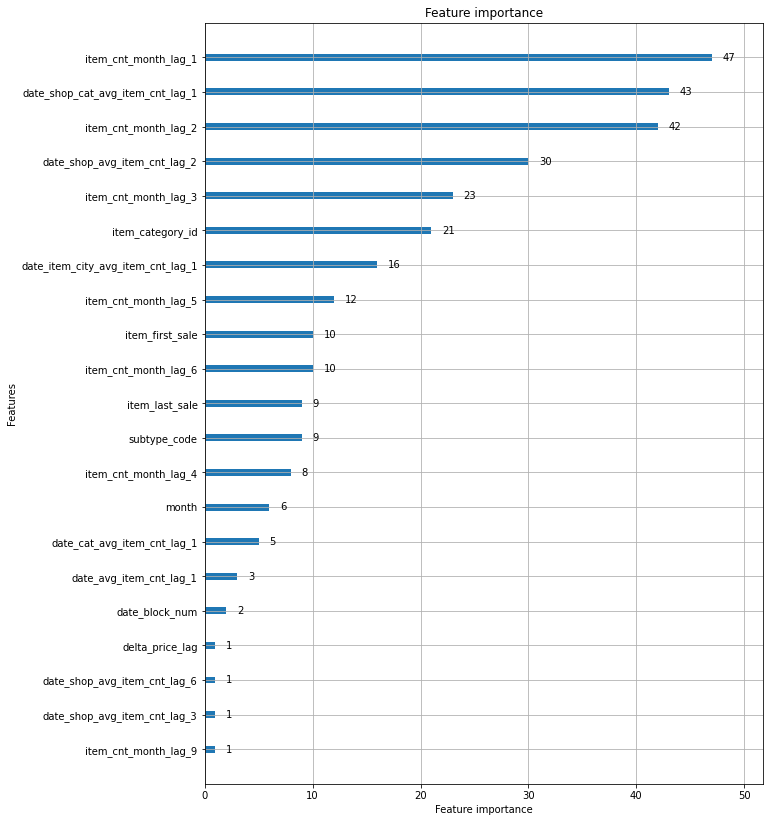

In [16]:
#importance = pd.DataFrame(model.feature_importance(), index=X_train.columns, columns=['importance'])
fig, ax = plt.subplots(1,1,figsize=(10, 14))
lgb.plot_importance(booster=model, ax=ax)

In [17]:

score

0.9176699313782695